# Explainable AI - LIME

## Imports

In [1]:
import lime
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
import lime.lime_tabular
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from lime.lime_tabular import LimeTabularExplainer

## Loading

### Model

In [2]:
model = load_model('/kaggle/input/6-data-for-explainableai/baseline_model.h5', compile=False)

### Data

In [3]:
data_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_test.csv')
data_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_train.csv')
data_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_val.csv')

labels_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_test.csv')
labels_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_train.csv')
labels_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_val.csv')

## Create data generators

In [4]:
# This class is a customer data generator 
# It's purpose is to load, preprocess and supply data in batches during training
# It's there because it is inefficient to load large datasets at once
    
class ECG_DataGen(tf.keras.utils.Sequence):    
# Contructor - Takes a list of ECG files and labels, batch size (number of samples ), sample length (number of data points in each ECG signal), and an option to shuffle the data. 
    def __init__(self, df_files, df_labels, data_col, batch_size, sample_len, shuffle=True):
        #self is an instance of the class #it should be passed as first parameter in all methods
        
        self.df_files = df_files.copy()
        self.df_labels = df_labels.copy()
        self.data_col = data_col
        self.n_samples = len(self.df_files)
        self.sample_len = sample_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return self.n_samples // self.batch_size
    
#     applies low pass filter
    def low_pass_filter(self, voltages, window_size):
        """Applies a moving average low-pass filter to a 1D array of voltages."""
        # Create a windowed version of the array
        window = np.ones(window_size) / window_size
        filtered_voltages = np.convolve(voltages, window, mode='same')
        return filtered_voltages
    
#    normalizes data and apply low pass filter
    def scale(self, array):
        # Replace NaN values with 0.0
        array = np.nan_to_num(array, nan=0.0)
        
        #apply low pass filter
        array = self.low_pass_filter(array, window_size=100)

        # normalizing
        a_min = np.min(array)
        a_max = np.max(array)
        if a_max - a_min == 0:
            return np.zeros_like(array).reshape((-1, 1))
        return np.array((array - a_min) / (a_max - a_min))
       
#   TO BE SEARCHED  -  loads, preprocesses (filters and normalizes), and formats the data in chunks (batches) and returns it to the model.    
    def __getitem__(self, index):
        batch_leads = np.zeros((self.batch_size, self.sample_len, 12)) #create array with shape 128, 5000, 12
        batch_labels = np.zeros((self.batch_size, len(self.df_labels.columns)))

        for i in range(index*self.batch_size, (index+1)*self.batch_size):

            # load the ECG signals
            leads = scipy.io.loadmat(self.df_files.at[i, self.data_col])['val'] #loadmat() is a function to load matlab files #self.df_files.at[i, self.data_col] is the file path
            
            for j, lead_data in enumerate(leads): #iterate through 12 leads
                #preprocess data (normalize, filter)
                scaled_lead_data = self.scale(lead_data)
                
                batch_leads[i - index*self.batch_size, :, j] = scaled_lead_data.reshape((-1,))
            batch_labels[i - index*self.batch_size] = self.df_labels.loc[i].values

        return batch_leads, batch_labels

    #  called at the end of every training epoch to shuffle data after every epoch
    def on_epoch_end(self):
        if self.shuffle: 
            shuffle_idx = np.random.choice(range(self.n_samples), size=self.n_samples, replace=False)
            self.df_files = self.df_files.iloc[shuffle_idx].reset_index(drop=True)
            self.df_labels = self.df_labels.iloc[shuffle_idx].reset_index(drop=True)

In [5]:
data_col = 'ecg_filename'
sample_len = 5000
batch_size= 128

# Create data generators (Objects from ECG_DataGen class)
# These generators do not store the data themselves; instead, they load, preprocess, and return batches of ECG data and corresponding labels during model training or evaluation.
train_gen = ECG_DataGen(data_train, labels_train, data_col, batch_size, sample_len)
val_gen = ECG_DataGen(data_val, labels_val, data_col, batch_size, sample_len)
test_gen = ECG_DataGen(data_test, labels_test, data_col, len(data_test), sample_len)

In [6]:
# Extract a batch of data
X, _ = train_gen.__getitem__(0)  # Get the first batch
print(f"ECG data loaded successfully with shape: {X.shape}")

ECG data loaded successfully with shape: (128, 5000, 12)


# Initial Approach

In [ ]:
# Define feature names (12 leads with 5000 time points each)
# feature_names = [f'Lead {i+1} timepoint {j}' for i in range(12) for j in range(5000)]

class_names = ['ISCAL', 'NST_', 'SARRH', 'IVCD', '1AVB', 'STACH', 'VCLVH', 'STD_', 'IRBBB', 'PVC', 'ISC_', 'AFIB', 'LAFB', 'NDT', 'LVH', 'ASMI', 'IMI', 
               'ABQRS', 'NORM', 'SR']

feature_names = ['Lead_I', 'Lead_II', 'Lead_III', 'Lead_aVF', 'Lead_AVL', 'Lead_AVF', 'Lead_V1', 'Lead_V2', 'Lead_V3', 'Lead_V4', 'Lead_V5', 'Lead_V6']

## Methods

In [ ]:
# function to predict probabilities
def predict_fn(input_data):
    input_data = input_data.reshape(input_data.shape[0], 5000, 12)
    return model.predict(input_data)

In [ ]:
# Extract a batch of data from the generator using indexing (get the first batch)\
train_data_for_lime = X.reshape(X.shape[0], -1)  # Flatten the ECG data

In [ ]:
train_data_for_lime.shape

(10, 60000)

In [ ]:
print("Shape of train_data_for_lime:", train_data_for_lime.shape)
print("Length of feature_names2:", len(feature_names))


Shape of train_data_for_lime: (10, 60000)
Length of feature_names2: 12


In [ ]:
# LimeTabularExplainer is used to generate explanations for predictions made by machine learning models on tabular data

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_data_for_lime,  # The training data used by the model to learn patterns, should be 2D array
    feature_names=feature_names,        # List of feature names (e.g., column names) for better interpretation of the model
    class_names=class_names,            # List of possible output classes (labels), e.g., 'yes' and 'no' in a binary classification
    mode='classification'               # Specifies that the model is a classification model (not regression)
)

In [ ]:
#sample ecg input from validation set to explain
sample_input = np.array(val_gen[0][0][0]).flatten()  # Ensure it's a 1D array

In [ ]:
sample_input = X[:1].flatten()

In [ ]:
sample_input.shape

In [ ]:
# Generate explanations for a single input sample
# The explain_instance method creates an explanation for a particular data point (sample_input)
exp = explainer.explain_instance(
    sample_input,    # The specific data instance we want to explain (a row of input data)
    predict_fn,      # The model's prediction function; it takes the input and returns the predicted class probabilities
    num_features=12  # Limit the explanation to the top 12 most important features (the ones contributing most to the prediction)
)

In [ ]:
# show_in_notebook() displays a table that shows which features contributed the most to the prediction
exp.show_in_notebook(show_table=True)

In [ ]:
len(exp.as_list())

In [ ]:
# show_in_notebook() displays a table that shows which features contributed the most to the prediction
exp.show_in_notebook(show_table=True)

## Highlighting specific time points

In [ ]:
# Example raw ECG signals for 3 leads
time_points = np.arange(5000)  # Time points from 0 to 4999
ecg_data = sample_input.reshape(5000, 12)

# leads_12 = ['Lead_I', 'Lead_II', 'Lead III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
# leads = []

# for i in range(12):
#     lead = ecg_data[:, i]
#     ecg_leads.append(lead)

# Extract the ECG data for Lead 3, Lead 6, and Lead 11
lead_3 = ecg_data[:, 2]  # Lead 3 (index 2 since it's zero-indexed)
lead_6 = ecg_data[:, 5]  # Lead 6 (index 5)
lead_11 = ecg_data[:, 10]  # Lead 11 (index 10)

In [ ]:
# Highlighted time points from the LIME explanation
important_timepoints = {
    'Lead 3': [1462, 4861],
    'aVR': [1433, 4986],
    'aVF': [2237, 2611, 3169],
    'V1': [1241],
    'V3': [4102],
    'V5': [50, 204,1758]
}

In [ ]:
# Plot Lead 3, Lead 6, and Lead 11 with highlights on important time points
fig, axes = plt.subplots(6, 1, figsize=(10, 14), sharex=True)

# Plot Lead 3
axes[0].plot(time_points, ecg_data[:, 2], label='Lead 3', color='blue')
axes[0].scatter(important_timepoints['Lead 3'], lead_3[important_timepoints['Lead 3']], color='red', label='Important timepoint')
axes[0].set_title('Lead 3')
axes[0].legend()

# Plot Lead aVR
axes[1].plot(time_points, ecg_data[:, 5], label='Lead aVR', color='green')
axes[1].scatter(important_timepoints['aVR'], ecg_data[:, 3][important_timepoints['aVR']], color='red', label='Important timepoint')
axes[1].set_title('aVR')
axes[1].legend()

# Plot Lead aVF
axes[2].plot(time_points, ecg_data[:, 5], label='Lead aVF', color='green')
axes[2].scatter(important_timepoints['aVF'], ecg_data[:, 5][important_timepoints['aVF']], color='red', label='Important timepoint')
axes[2].set_title('aVF')
axes[2].legend()

# Plot Lead V1
axes[3].plot(time_points, ecg_data[:, 5], label='Lead V1', color='green')
axes[3].scatter(important_timepoints['V1'], ecg_data[:, 6][important_timepoints['V1']], color='red', label='Important timepoint')
axes[3].set_title('V1')
axes[3].legend()

# Plot Lead V3
axes[4].plot(time_points, ecg_data[:, 5], label='Lead V3', color='green')
axes[4].scatter(important_timepoints['V3'], ecg_data[:, 8][important_timepoints['V3']], color='red', label='Important timepoint')
axes[4].set_title('V3')
axes[4].legend()

# Plot Lead v5
axes[5].plot(time_points, ecg_data[:, 10], label='Lead v5', color='purple')
axes[5].scatter(important_timepoints['V5'], ecg_data[:, 10][important_timepoints['V5']], color='red', label='Important timepoint')
axes[5].set_title('V5')
axes[5].legend()

# Shared x-axis label
plt.xlabel('Time Points')

# Show the plot
plt.tight_layout()
plt.show()

## Automate visualization

In [ ]:
import re
# exp.as_list() returns the explanation as a list of (feature, importance) tuples,
# showing which features had the largest impact on the model's decision.
exp.as_list()

def extract_important_timepoints(exp, num_features=12):
    important_timepoints = {}
    
    # Define regex patterns
    lead_pattern = re.compile(r'Lead\s+(\d+)')
    timepoint_pattern = re.compile(r'timepoint\s+(\d+)')
    
    # Get the top features from the explanation
    for feature in exp.as_list()[:num_features]:
        #print('\nFeature:', feature)
        feature_str, _ = feature
        #print('Feature String:', feature_str)
        
        # Extract Lead and timepoint using regex
        lead_match = lead_pattern.search(feature_str)
        timepoint_match = timepoint_pattern.search(feature_str)
        
        if lead_match and timepoint_match:
            lead = f"Lead {lead_match.group(1)}"
            timepoint = int(timepoint_match.group(1))
            #print('Extracted Lead:', lead)
            #print('Extracted Timepoint:', timepoint)
            
            # Add the timepoint to the corresponding lead in the dictionary
            if lead not in important_timepoints:
                important_timepoints[lead] = []
            important_timepoints[lead].append(timepoint)
        else:
            print('Could not find Lead or timepoint in feature string.')
    
    return important_timepoints

# Get the important features (leads and timepoints) from the LIME explanation
important_timepoints = extract_important_timepoints(exp, num_features=1000)
#print("Extracted Important Timepoints:", important_timepoints)
# Reshape the sample input back to (5000, 12) to get the ECG data for all leads
ecg_data = sample_input.reshape(5000, 12)

# Define a mapping from lead names to lead indices (adjust if necessary)
lead_map = {
    'Lead 1': 0, 'Lead 2': 1, 'Lead 3': 2, 'Lead 4': 3, 'Lead 5': 4, 'Lead 6': 5,
    'Lead 7': 6, 'Lead 8': 7, 'Lead 9': 8, 'Lead 10': 9, 'Lead 11': 10, 'Lead 12': 11
}

if important_timepoints:
    # Plot each lead with its important time points
    fig, axes = plt.subplots(len(important_timepoints), 1, figsize=(10, len(important_timepoints) * 2), sharex=True)

    for i, (lead, timepoints) in enumerate(important_timepoints.items()):
        lead_idx = lead_map[lead]  # Map the lead name to the correct index
        lead_signal = ecg_data[:, lead_idx]  # Get the signal for the current lead
        
        axes[i].plot(np.arange(5000), lead_signal, label=lead, color='blue')
        axes[i].scatter(timepoints, lead_signal[timepoints], color='orange', label='Important timepoint', s=20)
        axes[i].set_title(lead)
        axes[i].legend()

    # Shared x-axis label
    plt.xlabel('Time Points')

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No important time points extracted.")

In [ ]:
# exp.as_list() returns the explanation as a list of (feature, importance) tuples,
# showing which features had the largest impact on the model's decision.
exp.as_list()

In [ ]:
def extract_important_timepoints(exp, num_features=12):
    important_timepoints = {}
    
    # Define regex patterns
    lead_pattern = re.compile(r'Lead\s+(\d+)')
    timepoint_pattern = re.compile(r'timepoint\s+(\d+)')
    
    # Get the top features from the explanation
    for feature in exp.as_list()[:num_features]:
        print('\nFeature:', feature)
        feature_str, _ = feature
        print('Feature String:', feature_str)
        
        # Extract Lead and timepoint using regex
        lead_match = lead_pattern.search(feature_str)
        timepoint_match = timepoint_pattern.search(feature_str)
        
        if lead_match and timepoint_match:
            lead = f"Lead {lead_match.group(1)}"
            timepoint = int(timepoint_match.group(1))
            print('Extracted Lead:', lead)
            print('Extracted Timepoint:', timepoint)
            
            # Add the timepoint to the corresponding lead in the dictionary
            if lead not in important_timepoints:
                important_timepoints[lead] = []
            important_timepoints[lead].append(timepoint)
        else:
            print('Could not find Lead or timepoint in feature string.')
    
    return important_timepoints

In [ ]:
# Get the important features (leads and timepoints) from the LIME explanation
important_timepoints = extract_important_timepoints(exp, num_features=12)
print("Extracted Important Timepoints:", important_timepoints)
# Reshape the sample input back to (5000, 12) to get the ECG data for all leads
ecg_data = sample_input.reshape(5000, 12)

# Define a mapping from lead names to lead indices (adjust if necessary)
lead_map = {
    'Lead 1': 0, 'Lead 2': 1, 'Lead 3': 2, 'Lead 4': 3, 'Lead 5': 4, 'Lead 6': 5,
    'Lead 7': 6, 'Lead 8': 7, 'Lead 9': 8, 'Lead 10': 9, 'Lead 11': 10, 'Lead 12': 11
}

if important_timepoints:
    # Plot each lead with its important time points
    fig, axes = plt.subplots(len(important_timepoints), 1, figsize=(10, len(important_timepoints) * 2), sharex=True)

    for i, (lead, timepoints) in enumerate(important_timepoints.items()):
        lead_idx = lead_map[lead]  # Map the lead name to the correct index
        lead_signal = ecg_data[:, lead_idx]  # Get the signal for the current lead
        
        axes[i].plot(np.arange(5000), lead_signal, label=lead, color='blue')
        axes[i].scatter(timepoints, lead_signal[timepoints], color='red', label='Important timepoint')
        axes[i].set_title(lead)
        axes[i].legend()

    # Shared x-axis label
    plt.xlabel('Time Points')

    # Show the plot
    plt.tight_layout()
    plt.show()
else:
    print("No important time points extracted.")

# 12 Features Approach

## Reshape training data

In [ ]:
# Reduce the 5000 data points per lead to a single summary statistic like the mean

# np.mean() calculates the average across a specified axis
# axis=1 indicates that the mean should be calculated along the second dimension (the time points), so mean is calculated for 5000 time points
train_data_simplified = np.mean(X, axis=1)  # Shape becomes (128, 12)
train_data_simplified.shape

In [ ]:
# value of Lead I for first ECG record - note all 5000 datapoints is represented by a single value
train_data_simplified[0][0]

## Set Up the LIME Explainer

In [ ]:
# Define feature names (12 leads with 5000 time points each)
# feature_names = [f'Lead {i+1} timepoint {j}' for i in range(12) for j in range(5000)]

class_names = ['ISCAL', 'NST_', 'SARRH', 'IVCD', '1AVB', 'STACH', 'VCLVH', 'STD_', 'IRBBB', 'PVC', 'ISC_', 'AFIB', 'LAFB', 'NDT', 'LVH', 'ASMI', 'IMI', 
               'ABQRS', 'NORM', 'SR']

feature_names = ['Lead_I', 'Lead_II', 'Lead_III', 'Lead_aVF', 'Lead_AVL', 'Lead_AVF', 'Lead_V1', 'Lead_V2', 'Lead_V3', 'Lead_V4', 'Lead_V5', 'Lead_V6']

In [ ]:
# Set up the explainer
explainer = LimeTabularExplainer(train_data_simplified, 
                                 feature_names=feature_names, 
                                 class_names=class_names, 
                                 mode='classification')

## Explain a Single Prediction

In [ ]:
record = X[0]

ecg_instance = np.mean(record, axis=0)
ecg_instance.shape

In [ ]:
new_ecg_data = X[:1].flatten()
new_ecg_data.shape

In [ ]:
# function to predict probabilities
def predict_fn(input_data):
    input_data = input_data.reshape(input_data.shape[0], 5000, 12)
    return model.predict(input_data)

In [ ]:
def predict_proba(input_data):    
    # Use model.predict to get the probabilities
    probabilities = model.predict(input_data)
    
    return probabilities

# Example use with LimeTabularExplainer
explanation = explainer.explain_instance(new_ecg_data, predict_fn, num_features=12)


In [ ]:
# Display the explanation in the notebook (for Jupyter)
explanation.show_in_notebook()

In [ ]:
prediction = model.predict(X_sample[:1])
predicted_disease_index = np.argmax(prediction)
disease = labels_train.columns[predicted_disease_index]
probability = np.max(prediction)*100

print('Predicted disease:', disease)
print('Probability:', probability)

# 20 Features approach

# 100 features with aggregated window

In [ ]:
# Flatten the input data for LIME
X_sample = X[:10]
X_sample_flattened = X_sample.reshape((X_sample.shape[0], -1))

In [ ]:
# Initialize LIME Tabular explainer
print("Initializing LIME Tabular Explainer...")
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_sample_flattened,
    feature_names=[f'Time_{i}_Lead_{j}' for j in range(12) for i in range(5000)],
    class_names=[f'Disease_{i}' for i in range(20)],
    mode='classification'
)
print("LIME Tabular Explainer initialized successfully.")

Initializing LIME Tabular Explainer...
LIME Tabular Explainer initialized successfully.


Attempt 1

In [ ]:
# Increase num_features for LIME
num_features = 12
record_idx = 0

print(f"Explaining instance {record_idx} with {num_features} features...")
exp = explainer.explain_instance(
    data_row=X_sample_flattened[record_idx],
    predict_fn=lambda x: model.predict(x.reshape((-1, 5000, 12))),
    num_features=num_features
)
print("Explanation completed.")

Explaining instance 0 with 12 features...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Explanation completed.


Attemp 2

In [ ]:
# Increase num_features for LIME
num_features = 100
record_idx = 0

print(f"Explaining instance {record_idx} with {num_features} features...")
exp = explainer.explain_instance(
    data_row=X_sample_flattened[record_idx],
    predict_fn=lambda x: model.predict(x.reshape((-1, 5000, 12))),
    num_features=num_features
)
print("Explanation completed.")

Explaining instance 0 with 100 features...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Explanation completed.


In [ ]:
# show_in_notebook() displays a table that shows which features contributed the most to the prediction
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

[('Lead 5 timepoint 3215 <= 0.33', 2.6923838930287123e-05),
 ('Lead 10 timepoint 4300 <= 0.33', 2.5129669676817397e-05),
 ('Lead 1 timepoint 3716 > 0.63', 2.498014681388594e-05),
 ('0.31 < Lead 9 timepoint 698 <= 0.47', 2.4897537344586204e-05),
 ('Lead 6 timepoint 3142 <= 0.33', 2.482000963861023e-05),
 ('0.48 < Lead 9 timepoint 2844 <= 0.68', 2.433042694225938e-05),
 ('0.51 < Lead 2 timepoint 926 <= 0.70', 2.4145300562963973e-05),
 ('0.28 < Lead 10 timepoint 2761 <= 0.42', 2.392241316877751e-05),
 ('0.50 < Lead 12 timepoint 2703 <= 0.68', 2.372349910188398e-05),
 ('Lead 6 timepoint 3783 <= 0.25', 2.3674864016091665e-05),
 ('0.42 < Lead 2 timepoint 4750 <= 0.60', 2.3441417884267627e-05),
 ('0.29 < Lead 11 timepoint 1403 <= 0.59', 2.311026320374133e-05),
 ('Lead 8 timepoint 3640 > 0.60', 2.3041756049590235e-05),
 ('Lead 5 timepoint 937 > 0.58', 2.2631534609981647e-05),
 ('0.36 < Lead 9 timepoint 3460 <= 0.66', 2.2142279869576064e-05),
 ('Lead 7 timepoint 4525 <= 0.26', 2.206687167805694

Highlighted points count for Lead 1: 4
Highlighted points count for Lead 2: 10
Highlighted points count for Lead 3: 4
Highlighted points count for Lead 4: 4
Highlighted points count for Lead 5: 4
Highlighted points count for Lead 6: 7
Highlighted points count for Lead 7: 9
Highlighted points count for Lead 8: 2
Highlighted points count for Lead 9: 6
Highlighted points count for Lead 10: 11
Highlighted points count for Lead 11: 6
Highlighted points count for Lead 12: 7


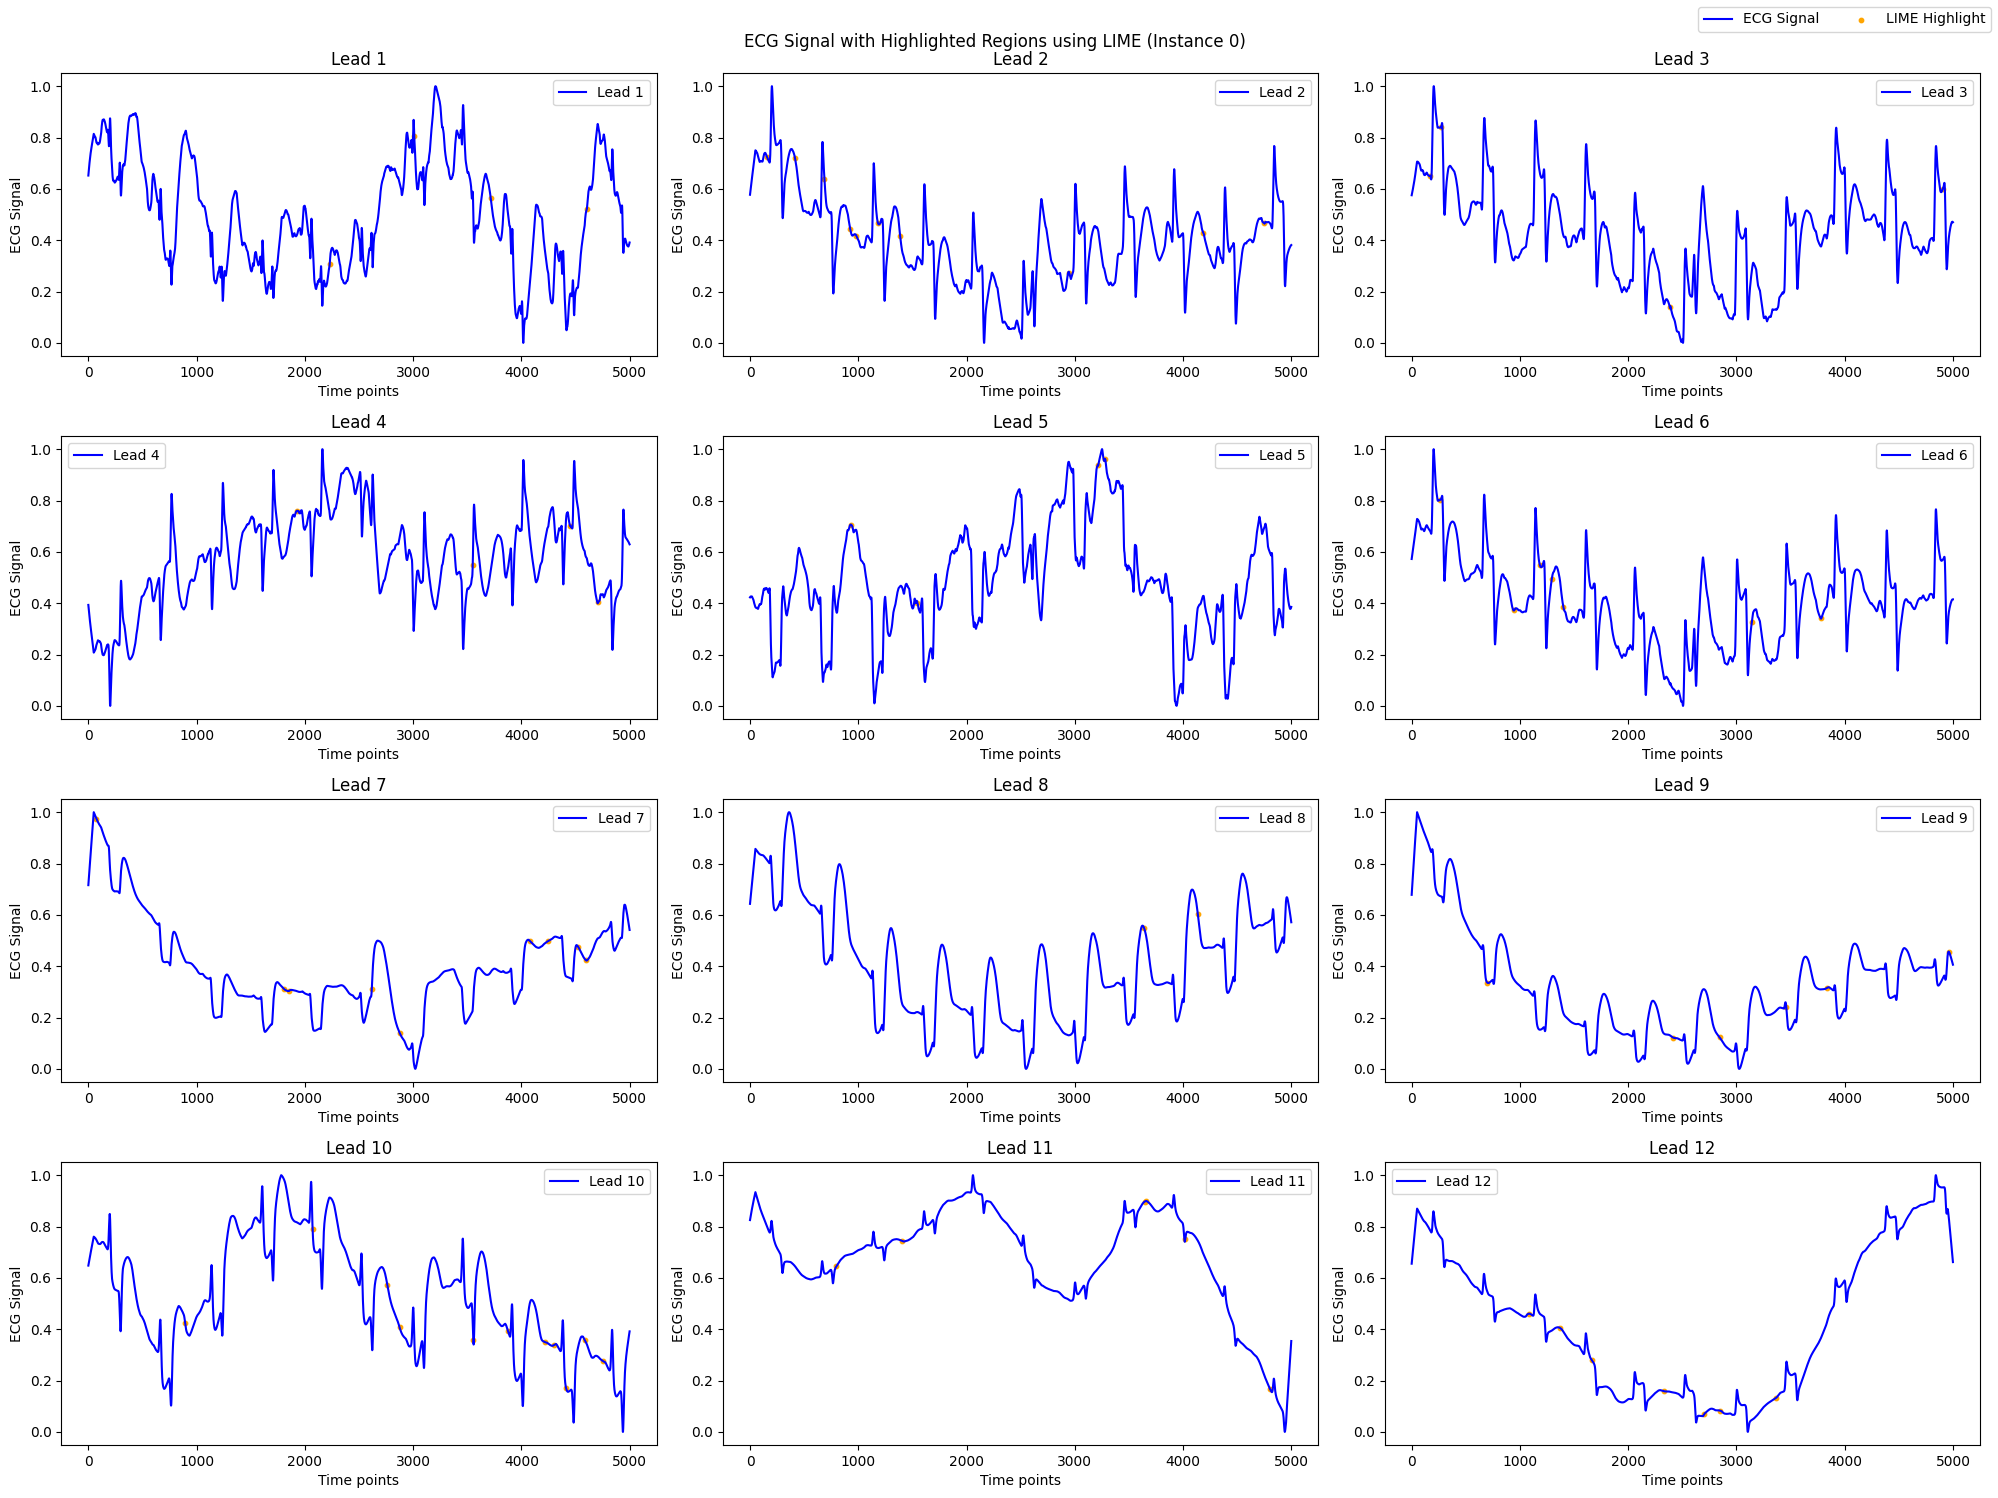

In [ ]:
# Visualize the ECG signal with aggregated highlighted regions
plt.figure(figsize=(20, 15))
plot_count = 0
aggregation_window = 25  # Number of points to aggregate around each highlighted point #when window = 25, total points = roughly 4000

for lead in range(12):
    ecg_signal = X_sample[record_idx, :, lead]

    # Highlight regions based on LIME explanation
    highlighted_points = set()
    for (feature, weight) in exp.as_list():
        if f'Lead {lead + 1} timepoint' in feature and weight > 0:
            time_idx = int(feature.split('timepoint ')[1].split()[0])
            highlighted_points.add(time_idx)

    if highlighted_points:
        count = len(highlighted_points)
        plot_count += 1
        plt.subplot(4, 3, plot_count)
        plt.plot(ecg_signal, color='blue', label=f'Lead {lead + 1}')
        plt.scatter(list(highlighted_points), [ecg_signal[i] for i in highlighted_points], color='orange', s=10)
        print(f"Highlighted points count for Lead {lead + 1}: {count}")
        plt.title(f'Lead {lead + 1}')
        plt.xlabel('Time points')
        plt.ylabel('ECG Signal')
        plt.legend()
    else:
        print(f"No regions highlighted for Lead {lead + 1}")

if plot_count > 0:
    plt.figlegend(['ECG Signal', 'LIME Highlight'], loc='upper right', ncol=2)
    plt.suptitle(f'ECG Signal with Highlighted Regions using LIME (Instance {record_idx})')
    plt.tight_layout()
    plt.show()
else:
    print("No leads with highlighted regions to plot.")


In [7]:
# Extract a batch of data
X, y = train_gen.__getitem__(0)  # Get the first batch
print(f"ECG data loaded successfully with shape: {X.shape}")

# Select a subset of the data for explanation
print("Selecting a subset of the data for LIME explanation...")
X_sample = X[:10]  # Take first 10 samples as an example
print(f"Subset selected with shape: {X_sample.shape}")

# Flatten the input data for LIME
X_sample_flattened = X_sample.reshape((X_sample.shape[0], -1))

# Initialize LIME Tabular explainer
print("Initializing LIME Tabular Explainer...")
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_sample_flattened,
    feature_names=[f'Time_{i}_Lead_{j}' for j in range(12) for i in range(5000)],
    class_names=[f'Disease_{i}' for i in range(20)],
    mode='classification'
)
print("LIME Tabular Explainer initialized successfully.")

# Explain a specific instance
record_idx = 0
print(f"Explaining instance {record_idx}...")
exp = explainer.explain_instance(
    data_row=X_sample_flattened[record_idx],
    predict_fn=lambda x: model.predict(x.reshape((-1, 5000, 12))),
    num_features=20
)
print("Explanation completed.")

ECG data loaded successfully with shape: (128, 5000, 12)
Selecting a subset of the data for LIME explanation...
Subset selected with shape: (10, 5000, 12)
Initializing LIME Tabular Explainer...
LIME Tabular Explainer initialized successfully.
Explaining instance 0...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Explanation completed.


Highlighted points count for Lead 1: 1
Highlighted points count for Lead 2: 6
Highlighted points count for Lead 3: 1
Highlighted points count for Lead 4: 1
No regions highlighted for Lead 5
Highlighted points count for Lead 6: 1
Highlighted points count for Lead 7: 2
Highlighted points count for Lead 8: 1
Highlighted points count for Lead 9: 1
Highlighted points count for Lead 10: 1
Highlighted points count for Lead 11: 2
Highlighted points count for Lead 12: 2


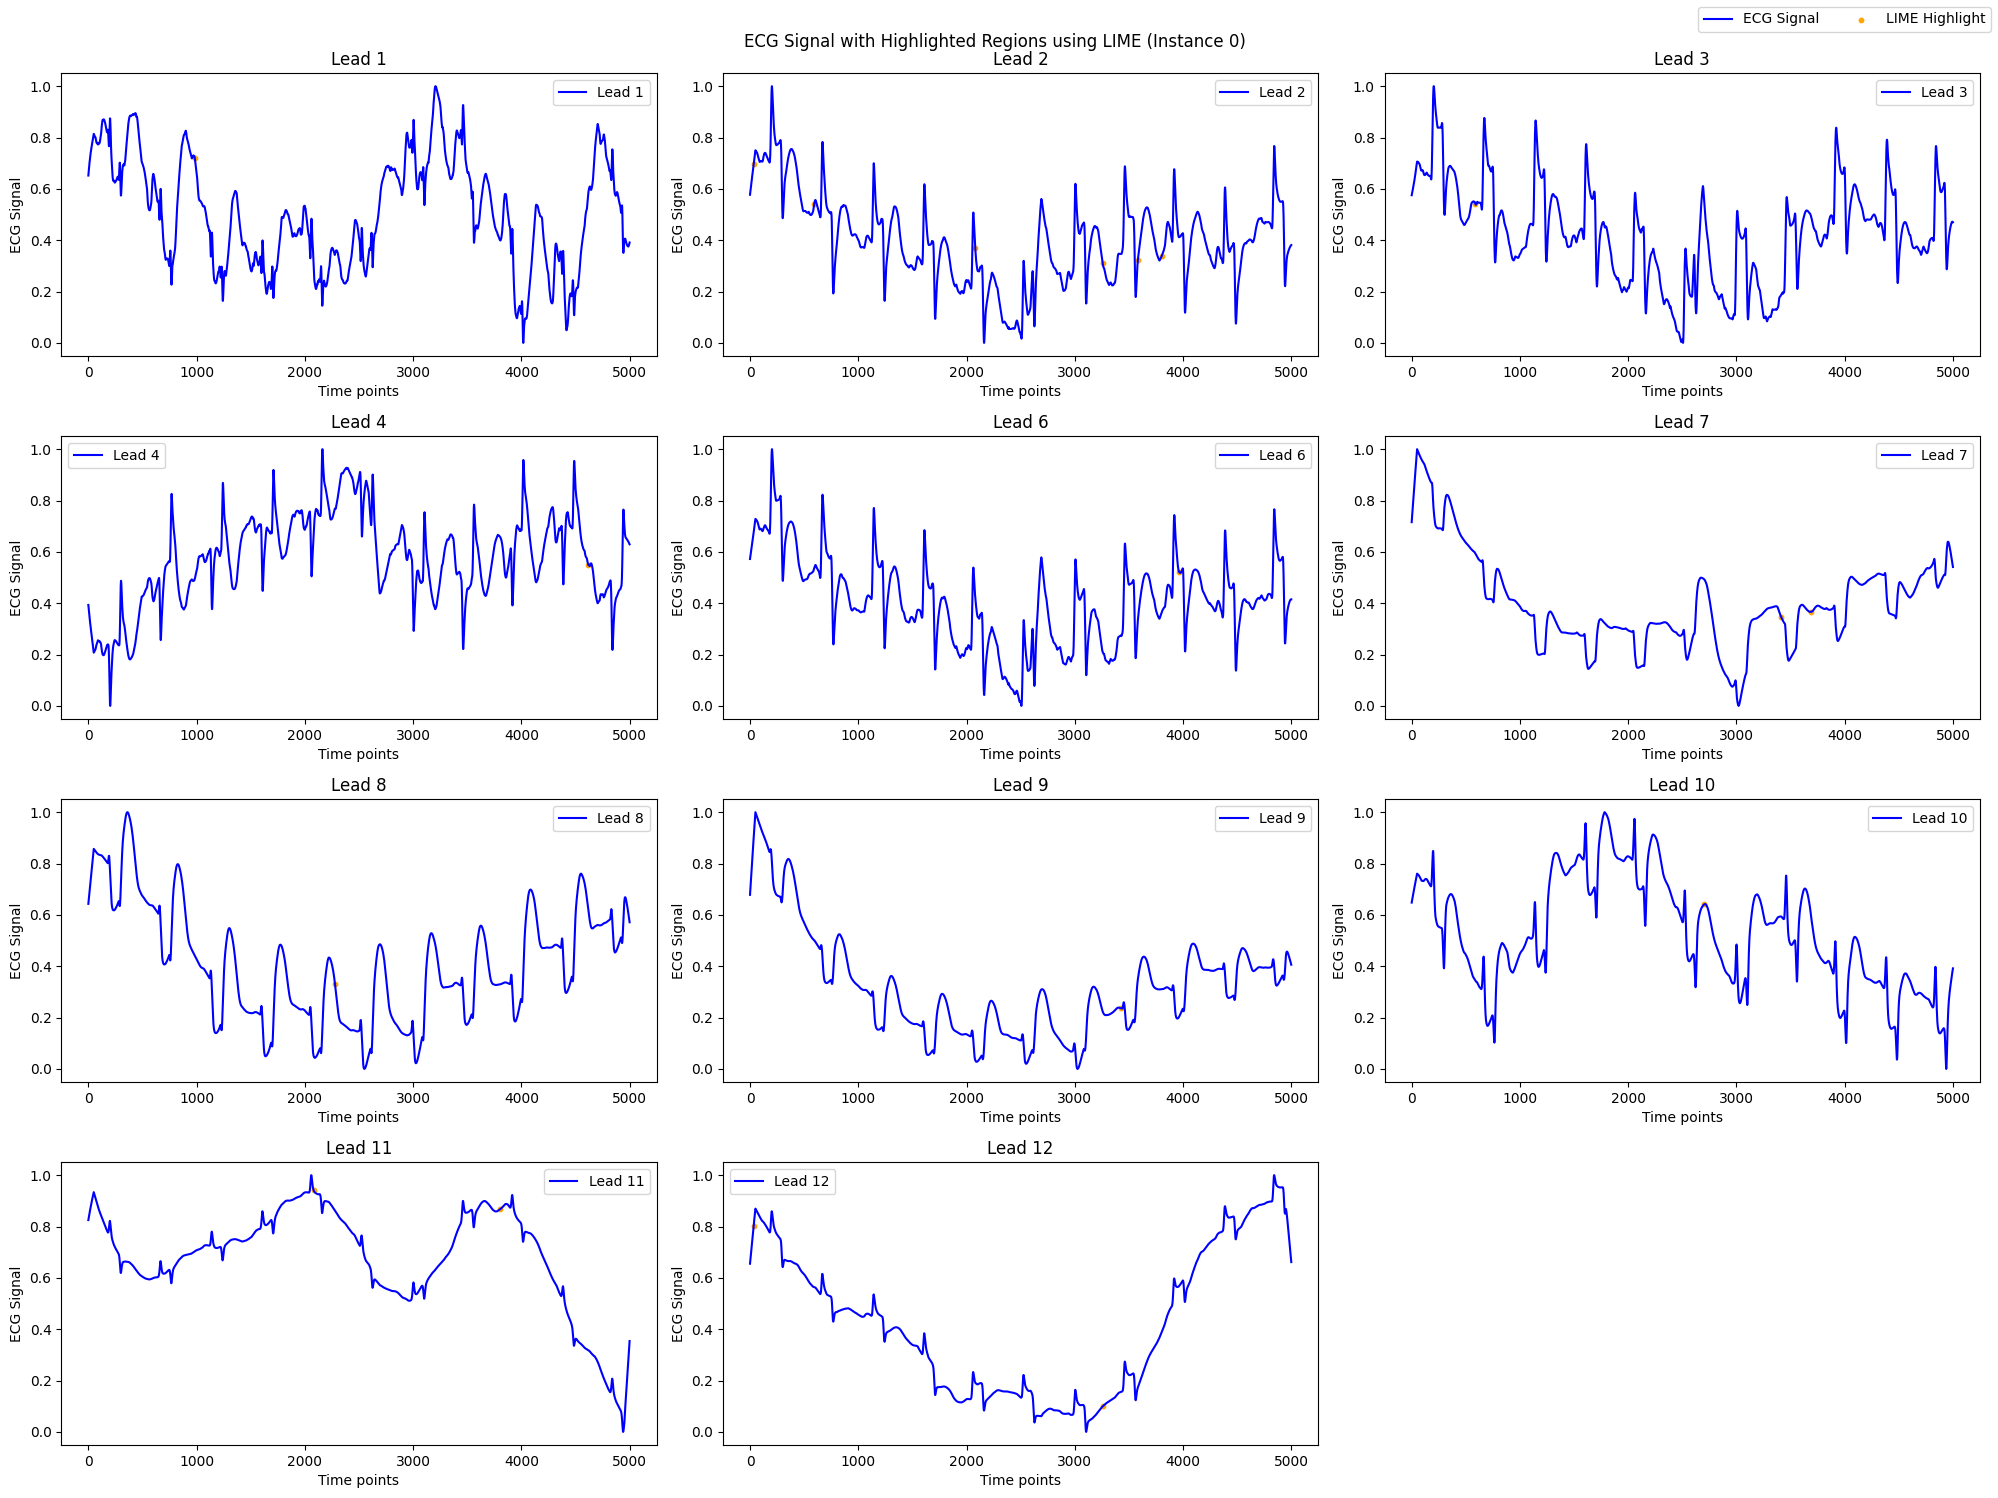

In [19]:
# Visualize the ECG signal with LIME highlighted regions
plt.figure(figsize=(20, 15))
plot_count = 0

for lead in range(12):
    ecg_signal = X_sample[record_idx, :, lead]

    # Highlight regions based on LIME explanation
    highlighted_points = set()
    for (feature, weight) in exp.as_list():
        if f'Lead_{lead}' in feature and weight > 0:
            time_idx = int(feature.split('_')[1])
            highlighted_points.add(time_idx)

    if highlighted_points:
        count = len(highlighted_points)
        plot_count += 1
        plt.subplot(4, 3, plot_count)
        plt.plot(ecg_signal, color='blue', label=f'Lead {lead + 1}')
        plt.scatter(list(highlighted_points), [ecg_signal[i] for i in highlighted_points], color='orange', s=10)
        print(f"Highlighted points count for Lead {lead + 1}: {count}")
        plt.title(f'Lead {lead + 1}')
        plt.xlabel('Time points')
        plt.ylabel('ECG Signal')
        plt.legend()
    else:
        print(f"No regions highlighted for Lead {lead + 1}")

if plot_count > 0:
    plt.figlegend(['ECG Signal', 'LIME Highlight'], loc='upper right', ncol=2)
    plt.suptitle(f'ECG Signal with Highlighted Regions using LIME (Instance {record_idx})')
    plt.tight_layout()
    plt.show()
else:
    print("No leads with highlighted regions to plot.")

# 60,000 features approach

## Flatten the ECG Data

In [10]:
training_data_flattened = X.reshape(128, 60000)  # Flatten each record
training_data_flattened.shape

(128, 60000)

## Set Up the LIME Explainer

In [12]:
# Define feature names (12 leads with 5000 time points each)
feature_names = [f'Lead {i+1} timepoint {j}' for i in range(12) for j in range(5000)]

class_names = ['ISCAL', 'NST_', 'SARRH', 'IVCD', '1AVB', 'STACH', 'VCLVH', 'STD_', 'IRBBB', 'PVC', 'ISC_', 'AFIB', 'LAFB', 'NDT', 'LVH', 'ASMI', 'IMI', 
               'ABQRS', 'NORM', 'SR']

In [13]:
# Set up the explainer with 60,000 features
explainer = LimeTabularExplainer(training_data_flattened,  # This should be training data flattened to shape (128, 60000)
                                 feature_names=feature_names,
                                 class_names=class_names,  # Replace with actual class names
                                 mode='classification')

## Explain a Single Instance

In [ ]:
X[:1].shape

In [ ]:
# Sample input
ecg_instance = X[:1]
ecg_instance.shape

sample_input = X[:1].flatten()
sample_input.shape

In [ ]:
# function to predict probabilities
def predict_fn(input_data):
    input_data = input_data.reshape(input_data.shape[0], 5000, 12)
    input_data.shape
    return model.predict(input_data)


In [ ]:
sample_input.shape

In [ ]:
ecg_instance[0].shape

In [ ]:
# Use LIME with the original input data (not flattened)
explanation = explainer.explain_instance(sample_input, predict_fn, num_features=10)

In [ ]:
# Show the explanation
explanation.show_in_notebook()